<a href="https://colab.research.google.com/github/Fahma-n/Driver-Drowsiness-Detection/blob/master/Copy_of_Copy_of_Energy_forecasting_hour_24_3_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATASET

In [ ]:
from google.colab import drive
drive.mount("mydrive")

Mounted at mydrive


In [ ]:
!cp /content/mydrive/MyDrive/HomeC.csv   /content/

# Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,LSTM,Dense
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_squared_error,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
import warnings
warnings.simplefilter('ignore')
from tensorflow.keras.utils import set_random_seed
set_random_seed(1233)

# utility methods

In [ ]:
def visualize(label, cols):
    fig,ax=plt.subplots(figsize=(14,8))
    colour= ['red','green','blue','yellow']
    for colour,col in zip(colour,cols):
            data.groupby(label)[col].mean().plot(ax=ax,label=col,color=colour)
    plt.legend()

# preprocessing : non  shiftable

In [ ]:
# Load dataset using Pandas
data = pd.read_csv('/content/HomeC.csv')
# display sample dataset
data.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [ ]:
# remove last row
data = data[:-1]

<!-- remove last row -->


In [ ]:
# change data column names for our convenience

data.columns=['time', 'use', 'gen', 'House overall', 'Dishwasher',
       'Furnace 1', 'Furnace 2', 'Home office', 'Fridge',
       'Wine cellar', 'Garage door', 'Kitchen 12',
       'Kitchen 14', 'Kitchen 38', 'Barn', 'Well',
       'Microwave', 'Living room', 'Solar', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability']

data.head(3)

data['nonshift'] = data[['Furnace 1', 'Furnace 2', 'Home office', 'Fridge',
       'Wine cellar', 'Garage door', 'Kitchen 12',
       'Kitchen 14', 'Kitchen 38', 'Barn','Living room']].sum(axis=1)

In [ ]:
# we can remove icon and summary since the  temperature data will be enough
data=data.drop(['icon','summary'], axis =1)

In [ ]:
# remove shiftable devices and irrelevant columns
data=data.drop(['Dishwasher','Well','Microwave', 'House overall','use', 'gen', 'Solar'], axis =1)

In [ ]:
# aggregating similar columns

data['Furnace'] = data[['Furnace 1','Furnace 2']].sum(axis=1)
data['Kitchen'] = data[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1)
#removing the extras
data.drop(['Furnace 1','Furnace 2','Kitchen 12','Kitchen 14','Kitchen 38'], axis=1, inplace=True)

data.head()

,time,Home office,Fridge,Wine cellar,Garage door,Barn,Living room,temperature,humidity,visibility,...,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,nonshift,Furnace,Kitchen
0,1451624400,0.442633,0.124150,0.006983,0.013083,0.031350,0.001517,36.14,0.62,10.0,...,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0,0.702900,0.082617,0.000567
1,1451624401,0.444067,0.124000,0.006983,0.013117,0.031500,0.001650,36.14,0.62,10.0,...,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0,0.706417,0.084533,0.000567
2,1451624402,0.446067,0.123533,0.006983,0.013083,0.031517,0.001650,36.14,0.62,10.0,...,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0,0.706467,0.083017,0.000617
3,1451624403,0.446583,0.123133,0.006983,0.013000,0.031500,0.001617,36.14,0.62,10.0,...,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0,0.798883,0.175417,0.000650
4,1451624404,0.446533,0.122850,0.006850,0.012783,0.031500,0.001583,36.14,0.62,10.0,...,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0,0.923800,0.300917,0.000783


In [ ]:
# change 'cloudCover' with nearest value
data['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
data['cloudCover']=data['cloudCover'].astype('float')

In [ ]:
# check time in seconds
time = pd.to_datetime(data['time'],unit='s')
# Setting date time as index
time_index = pd.date_range('2016-01-01 05:00', periods=len(data),  freq='min') #Returns the range of equally spaced time points
time_index = pd.DatetimeIndex(time_index)
data['time']=time_index
data.index= data['time']


# Feature Engineering

In [ ]:
#getting  hour from the date column
data['day']= data['time'].dt.day
data['month']= data['time'].dt.month
data['week']= data['time'].dt.week
data['hour']= data['time'].dt.hour

Text(0, 0.5, 'power (kW)')

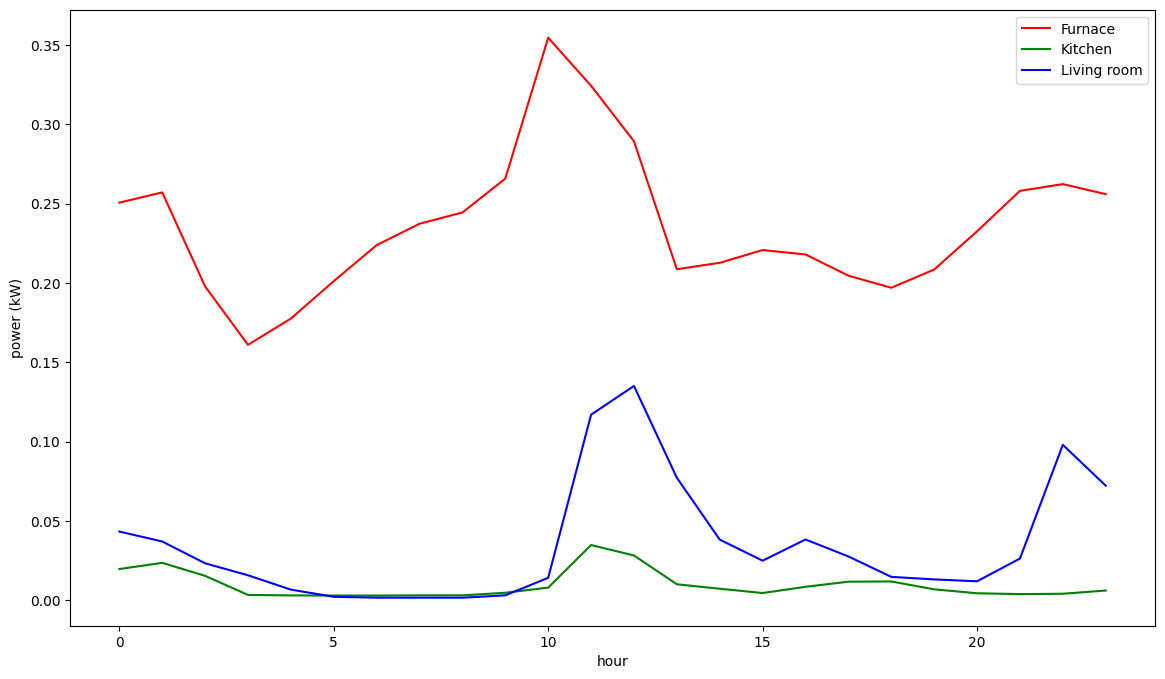

In [ ]:
visualize('hour',['Furnace','Kitchen','Living room'])
plt.xlabel('hour')
plt.ylabel('power (kW)')

In [ ]:
data['hour']

time
2016-01-01 05:00:00    5
2016-01-01 05:01:00    5
2016-01-01 05:02:00    5
2016-01-01 05:03:00    5
2016-01-01 05:04:00    5
                      ..
2016-12-16 03:25:00    3
2016-12-16 03:26:00    3
2016-12-16 03:27:00    3
2016-12-16 03:28:00    3
2016-12-16 03:29:00    3
Name: hour, Length: 503910, dtype: int64

In [ ]:
#hourly resampling
dataH=data.resample('H').mean()

In [ ]:
dataH.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8399 entries, 2016-01-01 05:00:00 to 2016-12-16 03:00:00
Freq: H
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Home office          8399 non-null   float64
 1   Fridge               8399 non-null   float64
 2   Wine cellar          8399 non-null   float64
 3   Garage door          8399 non-null   float64
 4   Barn                 8399 non-null   float64
 5   Living room          8399 non-null   float64
 6   temperature          8399 non-null   float64
 7   humidity             8399 non-null   float64
 8   visibility           8399 non-null   float64
 9   apparentTemperature  8399 non-null   float64
 10  pressure             8399 non-null   float64
 11  windSpeed            8399 non-null   float64
 12  cloudCover           8399 non-null   float64
 13  windBearing          8399 non-null   float64
 14  precipIntensity      8399 non-null   float64

In [ ]:
dataH

,Home office,Fridge,Wine cellar,Garage door,Barn,Living room,temperature,humidity,visibility,apparentTemperature,...,precipIntensity,dewPoint,precipProbability,nonshift,Furnace,Kitchen,day,month,week,hour
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 05:00:00,0.241814,0.037861,0.063351,0.013046,0.038881,0.001505,36.131000,0.619667,10.000000,29.264667,...,0.000000,24.383333,0.000,0.790466,0.393188,0.000821,1.0,1.0,53.0,5.0
2016-01-01 06:00:00,0.043294,0.075522,0.112942,0.012836,0.039181,0.001618,35.838667,0.610000,10.000000,29.364667,...,0.000000,23.866000,0.000,0.742849,0.456708,0.000749,1.0,1.0,53.0,6.0
2016-01-01 07:00:00,0.043416,0.059486,0.007184,0.013299,0.034439,0.001629,35.385000,0.613000,10.000000,29.034000,...,0.000000,23.469000,0.000,0.532349,0.372170,0.000726,1.0,1.0,53.0,7.0
2016-01-01 08:00:00,0.065014,0.060412,0.007045,0.012925,0.034195,0.001634,35.282000,0.640000,10.000000,30.395333,...,0.000000,24.202667,0.000,0.798401,0.616370,0.000806,1.0,1.0,53.0,8.0
2016-01-01 09:00:00,0.043392,0.035106,0.007143,0.013220,0.031830,0.001650,35.451667,0.641667,10.000000,29.673333,...,0.000000,24.423333,0.000,0.476978,0.343842,0.000796,1.0,1.0,53.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 23:00:00,0.041853,0.044236,0.008119,0.012814,0.032249,0.001261,36.990000,0.712000,9.380000,29.392667,...,0.000373,28.414667,0.008,0.913729,0.772467,0.000732,15.0,12.0,50.0,23.0
2016-12-16 00:00:00,0.041711,0.050492,0.105546,0.012526,0.030902,0.001236,37.584167,0.721667,8.855333,29.813667,...,0.004313,29.379167,0.182,1.039059,0.796006,0.000639,16.0,12.0,50.0,0.0
2016-12-16 01:00:00,0.041921,0.049140,0.123134,0.012743,0.031992,0.001276,36.429333,0.801000,8.576333,28.988000,...,0.010600,30.864333,0.510,1.084390,0.823418,0.000766,16.0,12.0,50.0,1.0


In [ ]:
dataH.rename(columns={ 'nonshift': 'y'}, inplace=True)
dataH['ds']  = dataH.index


# Prepare Data for models

In [ ]:
train_data = dataH.copy()
scaler = MinMaxScaler(feature_range=(0, 1))
dataH[['y']] = scaler.fit_transform(dataH[['y']])

In [ ]:
train = dataH.loc[dataH['ds'] < '2016-8-16 00:00:00']
test = dataH.loc[dataH['ds'] >= '2016-8-16 00:00:00']
ytest =test["y"].to_numpy()
test.drop('y',axis=1,inplace=True)


# fb Prophet

In [ ]:
!pip install prophet -q

In [ ]:
from prophet import Prophet

In [ ]:
m = Prophet()
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzd8qo2b1/4_a57f1h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzd8qo2b1/hq25bckm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87816', 'data', 'file=/tmp/tmpzd8qo2b1/4_a57f1h.json', 'init=/tmp/tmpzd8qo2b1/hq25bckm.json', 'output', 'file=/tmp/tmpzd8qo2b1/prophet_modeljt0apfvn/prophet_model-20230620151649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:16:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:16:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast_fb = m.predict(test)


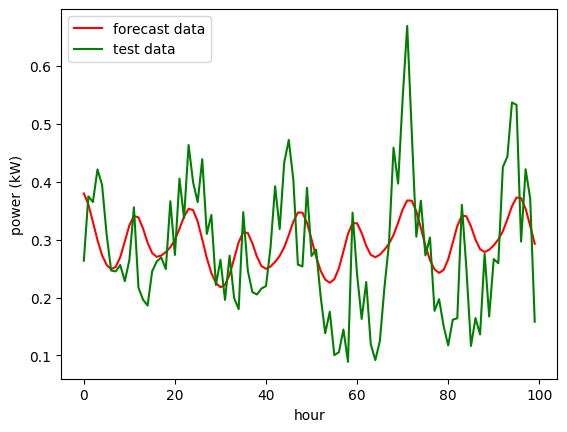

In [ ]:
pb_prophet = forecast_fb["yhat"].to_numpy()
plt.plot(pb_prophet[:100],c='red', label='forecast data')
plt.plot(ytest[:100],c='green', label='test data')
plt.xlabel('hour')
plt.ylabel('power (kW)')
plt.legend()
plt.show()

# lightgbm

In [ ]:
from lightgbm import LGBMRegressor


In [ ]:
xtrain = train.copy()
ytrain =xtrain["y"].to_numpy()
xtrain.drop('y',axis=1,inplace=True)
xtrain.drop('ds',axis=1,inplace=True)
xtest = test.copy()
xtest.drop('ds',axis=1,inplace=True)
xtest = xtest.to_numpy()

In [ ]:
lgb = LGBMRegressor()
# train model
lgb.fit(xtrain,ytrain)

LGBMRegressor()

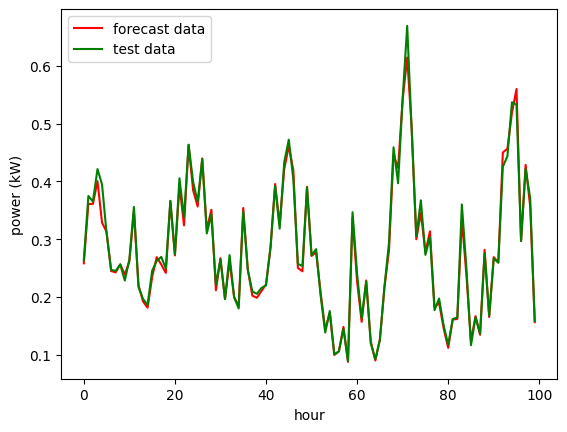

In [ ]:
forecast_lgb = lgb.predict(xtest)
plt.plot(forecast_lgb[:100],c='red', label='forecast data')
plt.plot(ytest[:100],c='green', label='test data')
plt.xlabel('hour')
plt.ylabel('power (kW)')
plt.legend()
plt.show()

#  xgboost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
# define xgb
xgb = XGBRegressor()
# fit xgb
xgb.fit(xtrain,ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

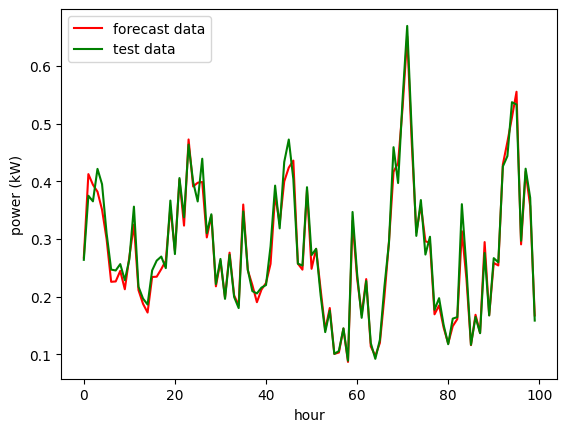

In [ ]:
forecast_xgb = xgb.predict(xtest)
plt.plot(forecast_xgb[:100],c='red', label='forecast data')
plt.plot(ytest[:100],c='green', label='test data')
plt.xlabel('hour')
plt.ylabel('power (kW)')
plt.legend()
plt.show()

#fusion 1

In [ ]:
# fusion

pb_xgb=xgb.predict(xtrain)
err1 = np.abs(pb_xgb -ytrain)
pb_lgb = lgb.predict(xtrain)
err2 = np.abs(pb_lgb -ytrain)


# find averages
a= 100-np.mean(err2,axis=0)*100
b= 100-np.mean(err1,axis=0)*100
# find weights
w1 = a/(a+b)
w2 = b/(a+b)


pb_xgb=xgb.predict(xtest)
pb_lgb = lgb.predict(xtest)

pb = w1*pb_lgb+ w2*pb_xgb
forecast_f = pb

In [ ]:
plt.plot(forecast_f[:100],c='red', label='forecast data')
plt.plot(ytest[:100],c='green', label='test data')
plt.legend()
plt.xlabel('hour')
plt.ylabel('power (kW)')
plt.title('fusion')
plt.show()


In [ ]:
f_mse = mean_squared_error(forecast_f,ytest,squared=False)
f_rmse=mean_squared_error(forecast_f,ytest,squared=True)
f_mae = mean_absolute_error(forecast_f,ytest)
f_mape = mean_absolute_percentage_error(forecast_f,ytest)

In [ ]:
lgb_mse = mean_squared_error(forecast_lgb,ytest,squared=False)
lgb_rmse=mean_squared_error(forecast_lgb,ytest,squared=True)
lgb_mae = mean_absolute_error(forecast_lgb,ytest)
lgb_mape = mean_absolute_percentage_error(forecast_lgb,ytest)

In [ ]:
fb_mse = mean_squared_error(pb_prophet,ytest,squared=False)
fb_rmse=mean_squared_error(pb_prophet,ytest,squared=True)
fb_mae = mean_absolute_error(pb_prophet,ytest)
fb_mape = mean_absolute_percentage_error(pb_prophet,ytest)

In [ ]:
xgb_mse = mean_squared_error(forecast_xgb,ytest,squared=False)
xgb_rmse=mean_squared_error(forecast_xgb,ytest,squared=True)
xgb_mae = mean_absolute_error(forecast_xgb,ytest)
xgb_mape = mean_absolute_percentage_error(forecast_xgb,ytest)

# Analysis

In [ ]:

print(" LGBM ")
print('mean_squared_error = ',lgb_mse )
print('root_mean_squared_error= ',lgb_rmse)
print('mean_absolute_error= ',lgb_mae )
print('mean_absolute_percentage_error= ',lgb_mape)
print("--------------------------------------------- ")
print(" XGB ")
print('mean_squared_error = ',xgb_mse )
print('root_mean_squared_error= ',xgb_rmse)
print('mean_absolute_error= ',xgb_mae )
print('mean_absolute_percentage_error= ',xgb_mape)
print("--------------------------------------------- ")
print(" fb prophet ")
print('mean_squared_error = ',fb_mse )
print('root_mean_squared_error= ',fb_rmse)
print('mean_absolute_error= ',fb_mae )
print('mean_absolute_percentage_error= ',fb_mape)

print("--------------------------------------------- ")

print(" fusion ")
print('mean_squared_error = ',f_mse )
print('root_mean_squared_error= ',f_rmse)
print('mean_absolute_error= ',f_mae )
print('mean_absolute_percentage_error= ',f_mape)

 LGBM 
mean_squared_error =  0.013578250968901303
root_mean_squared_error=  0.00018436889937446918
mean_absolute_error=  0.007186117559050585
mean_absolute_percentage_error=  0.0297476104421776
--------------------------------------------- 
 XGB 
mean_squared_error =  0.015143787904186367
root_mean_squared_error=  0.00022933431208698132
mean_absolute_error=  0.009015743440186895
mean_absolute_percentage_error=  0.03752041223831074
--------------------------------------------- 
 fb prophet 
mean_squared_error =  0.2698622599101125
root_mean_squared_error=  0.0728256393237931
mean_absolute_error=  0.24868610742081187
mean_absolute_percentage_error=  0.5346735179001078
--------------------------------------------- 
 fusion 
mean_squared_error =  0.012793825957258491
root_mean_squared_error=  0.00016368198262462115
mean_absolute_error=  0.006899147518886403
mean_absolute_percentage_error=  0.028141075272004015


Time slots with minimum energy consumption

In [ ]:
forecast_ff = forecast_f[:2928]
n = int(forecast_ff.shape[0]/24)
f = forecast_ff.reshape((24,n))
f= np.mean(f,axis=1)
sdata = np.argsort(f)
#take minimum 5 hrs
s5 = sdata[:5]
f2 = np.zeros(f.shape)
f2[s5] = f[s5]
s5 = s5+1
print(" min hrs : ",s5)
n=np.zeros((24,1))
n[s5-1] = 0.2

 min hrs :  [ 7 11  8 12  9]


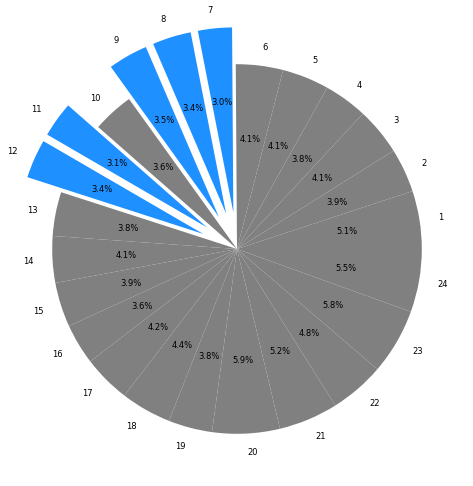

In [ ]:
plt.figure(figsize=[10,10],dpi=60)
mylist = ["dodgerblue" if f else 'grey' for f in f2]
plt.pie(f,labels=[str(i) for i in range(1,25)],autopct='%1.1f%%',explode=list(n.reshape(1,24)[0]),colors=mylist)
plt.show()

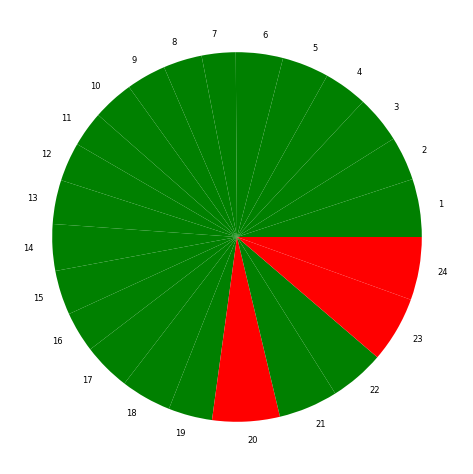

In [ ]:
threshold =0.28
values = f>threshold
mylist = ["red" if value else 'green' for value in values]
plt.figure(figsize=[10,10],dpi=60)
plt.pie(f,labels=[str(i) for i in range(1,25)],colors=mylist)
plt.show()